In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

sys.path.append("../")

import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from model import build_model
from clip_ import load, tokenize, similarity_score
from vit_cam import interpret_vit, interpret_vit_overlapped
from rn_cam import interpret_rn, interpret_rn_overlapped

sys.path.append("../pytorch-grad-cam")
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model_rn, preprocess = load("RN101", device=device, jit=False)
model_vit, preprocess = load("ViT-B/32", device=device, jit=False)

In [4]:
model_types = ["ViT", "ResNet"]

root = "../../Images/"

res_dir = "../../results/global_vis/"
if not os.path.exists(res_dir):
    os.mkdir(res_dir)
    
img_ids = ['rainy_night', 'scary_painting_colorful', 'scary_painting', 'sad_woman', 'happy_woman', 'sad_woman_colorful', 'happy_woman_b&w']
text_lists = [ 
        ["rainy autumn night","bright sunny day"],
        ["an image of a scary clown","an image of a funny clown"],
        ["a scary image","a cute image"],
        ["an image of a sad woman with yellow background","an image of a happy woman at the beach"],
        ["happy woman with pink shirt","sad woman with pink shirt"],
        ["a sad woman with yellow background","a happy woman at the beach"],
        ["this person is happy","this woman is sad"]]


font = {
    'size': 20,
}

ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
        CenterCrop(size=(224, 224)),
        ToTensor()])

/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


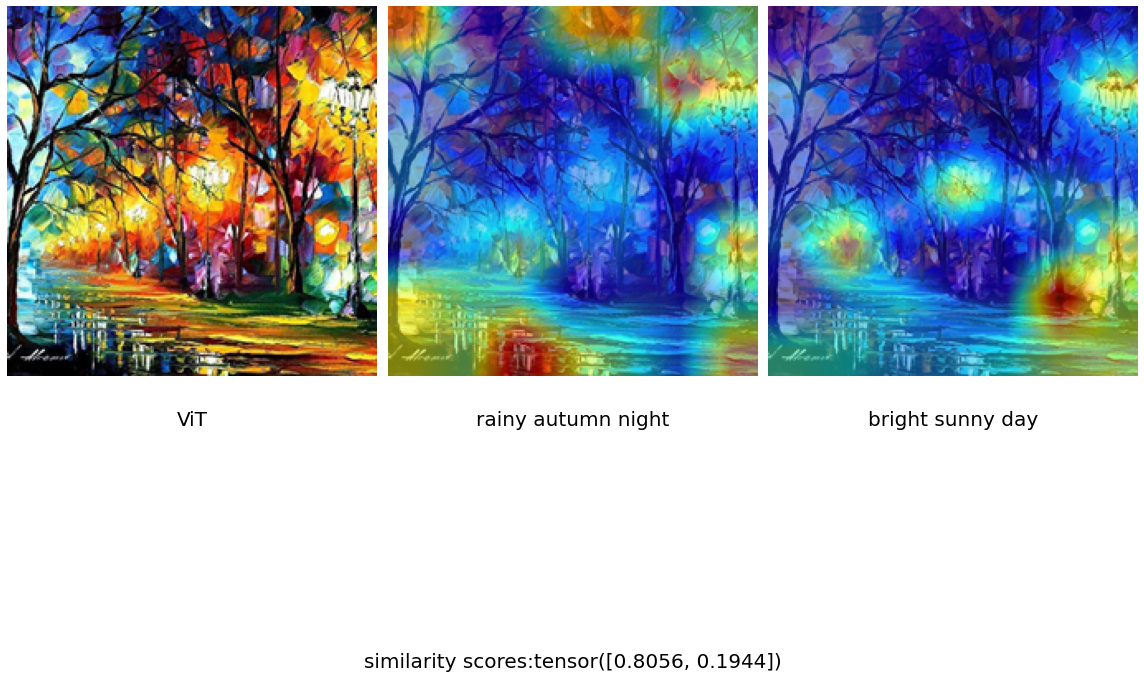

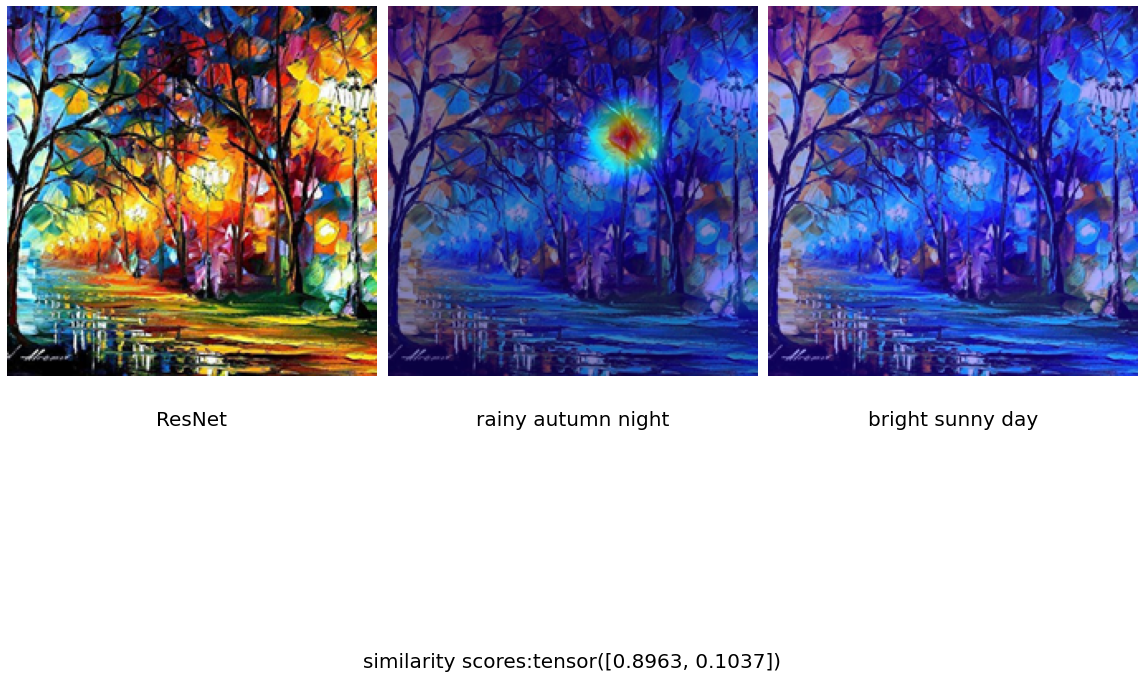

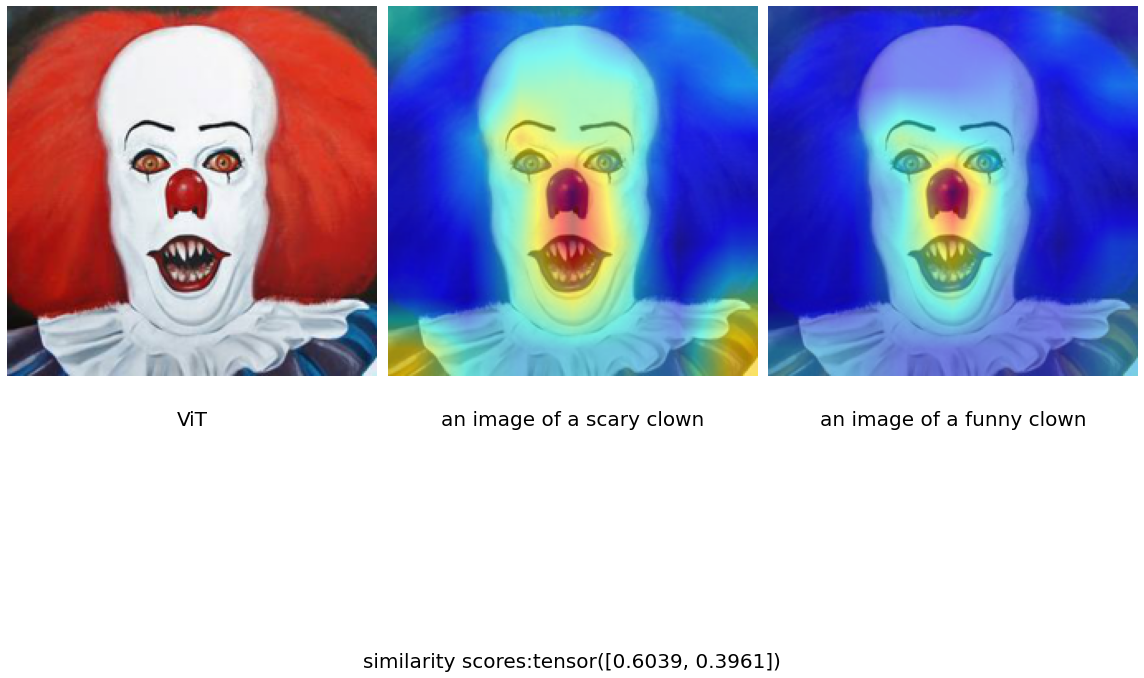

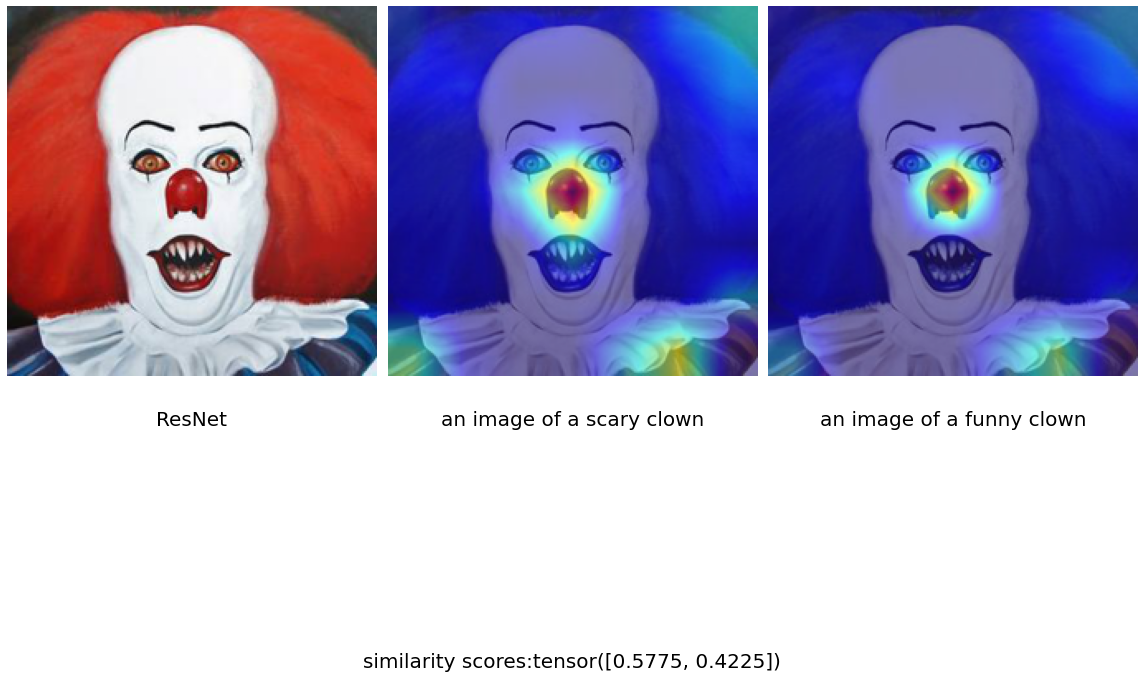

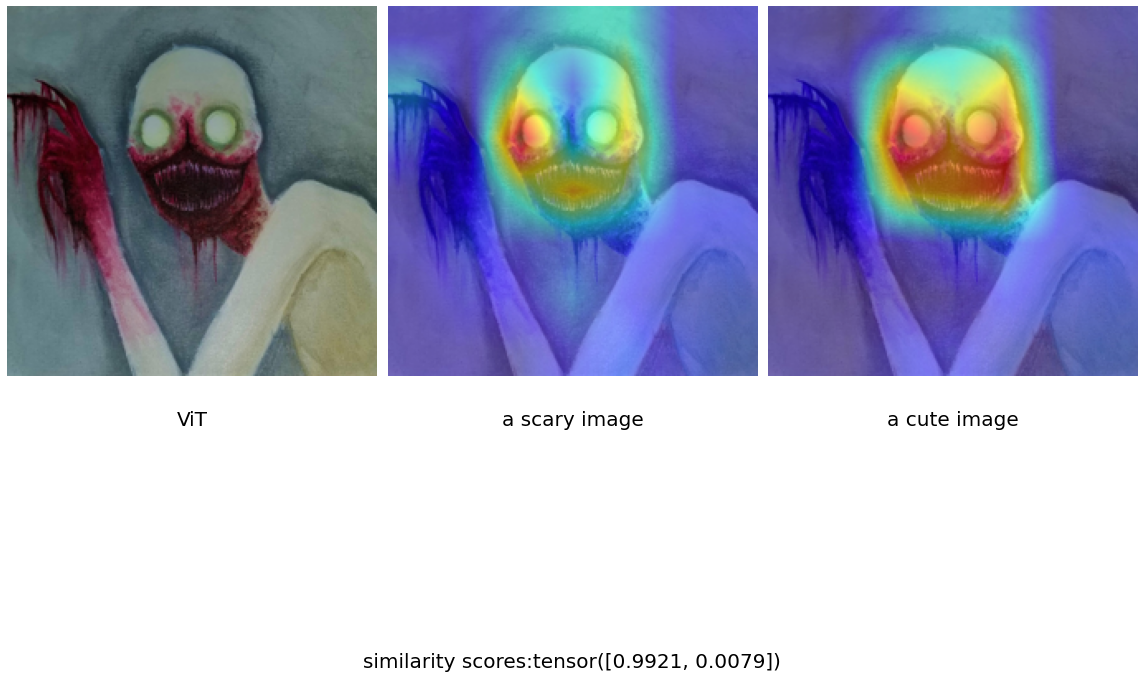

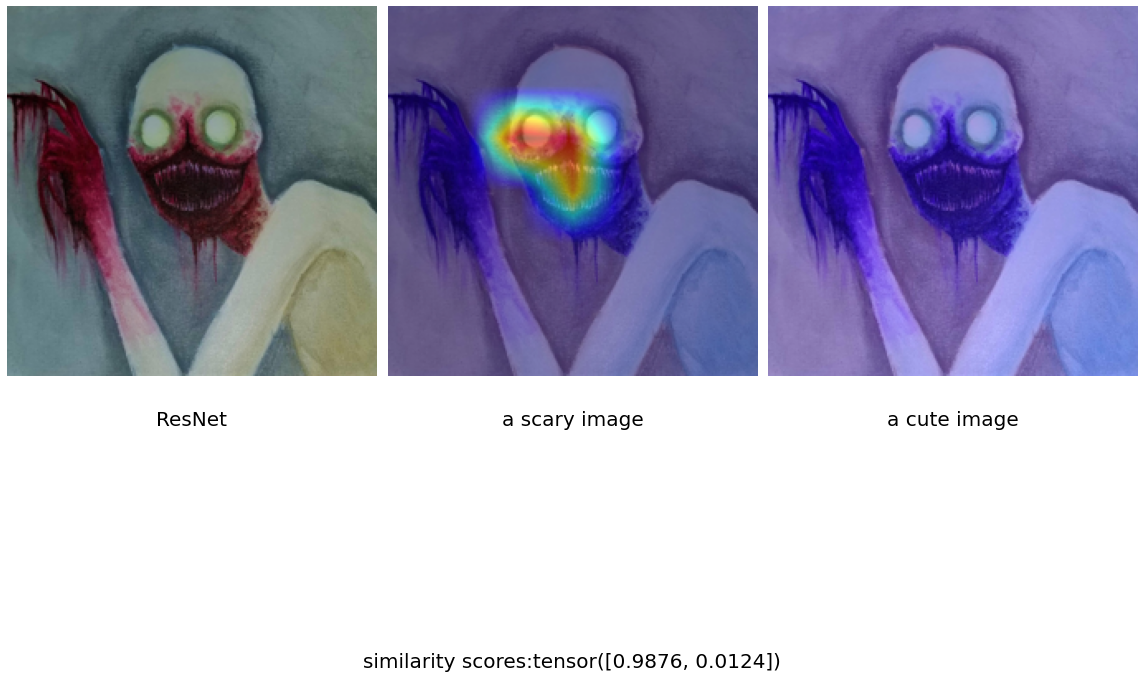

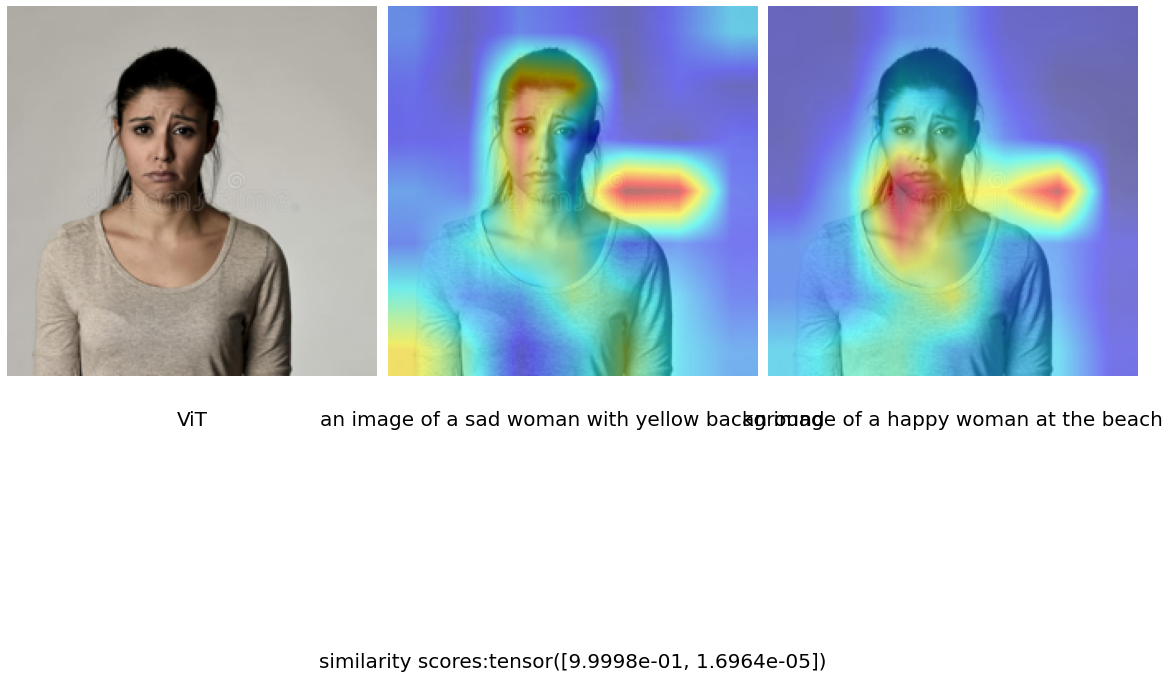

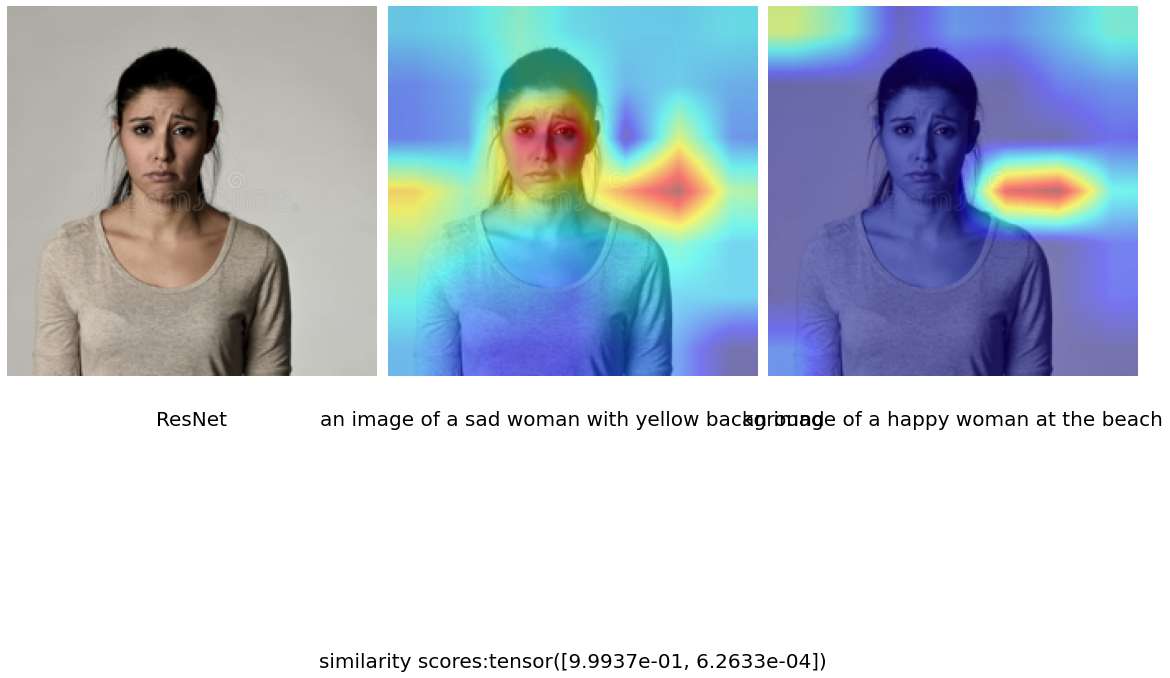

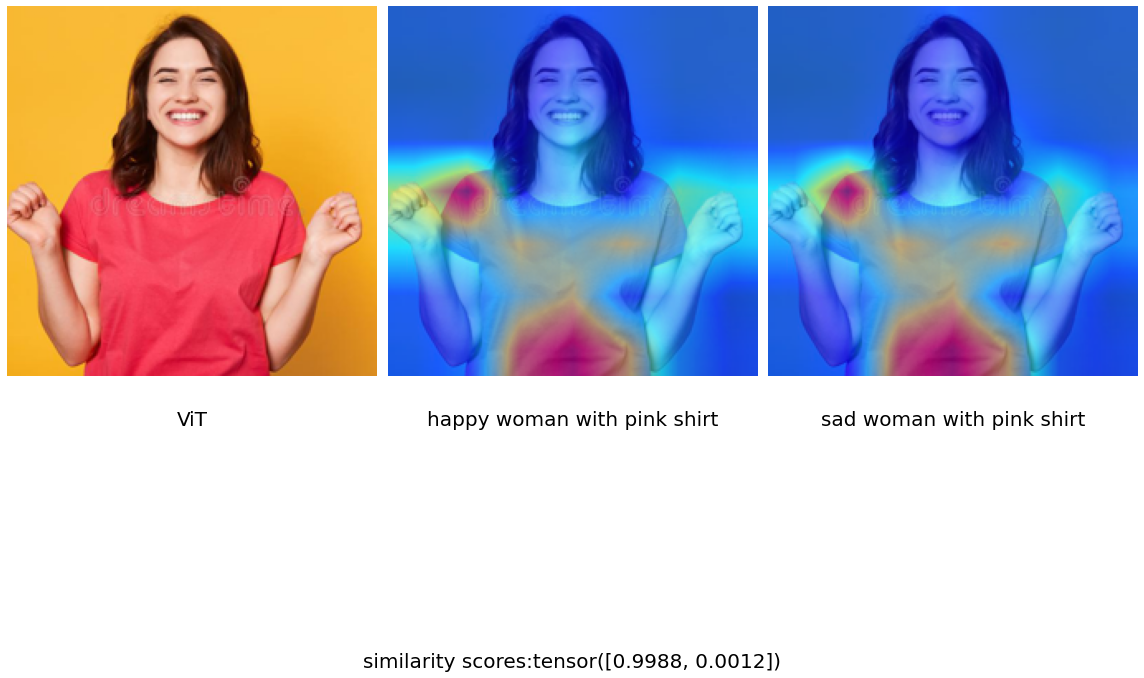

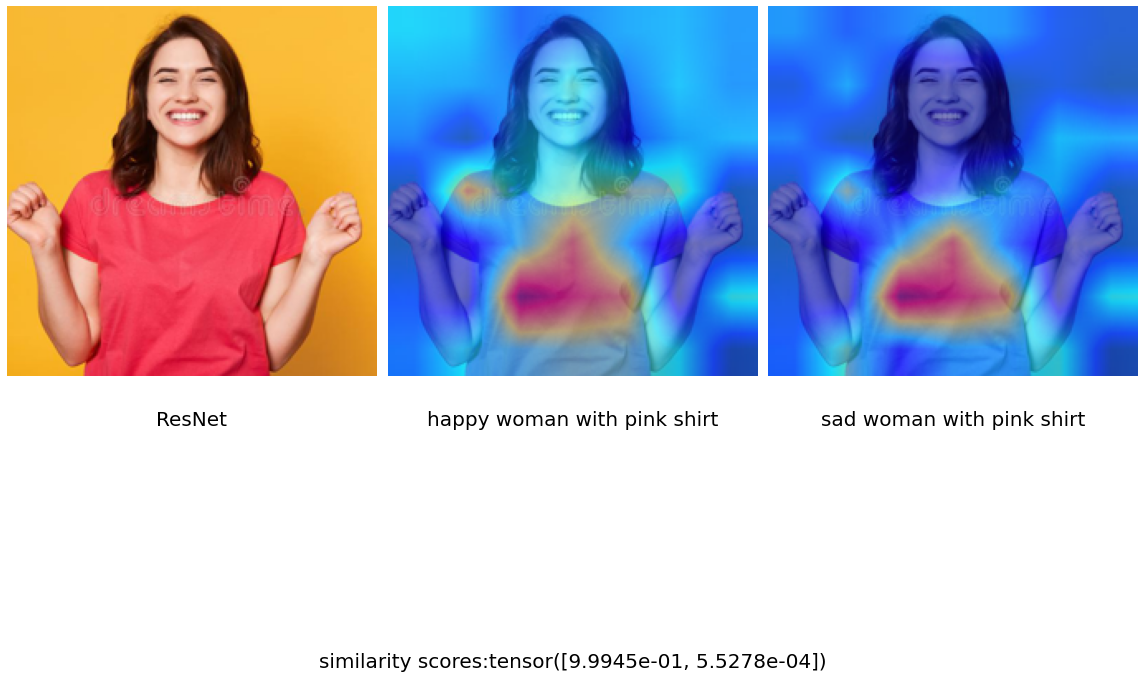

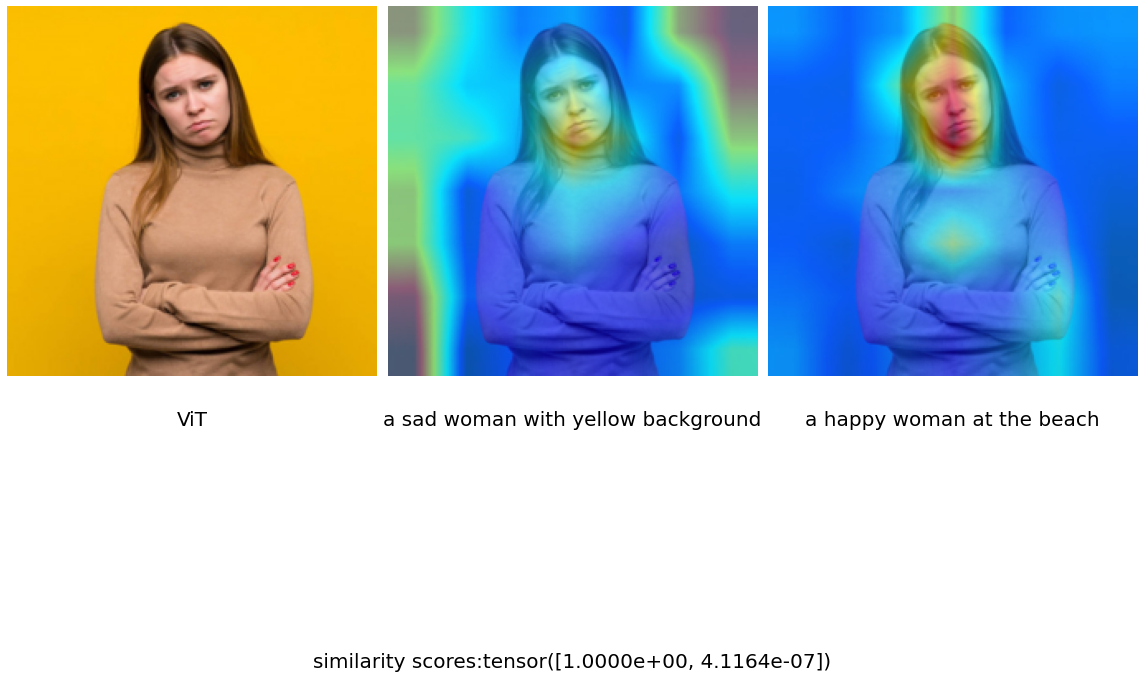

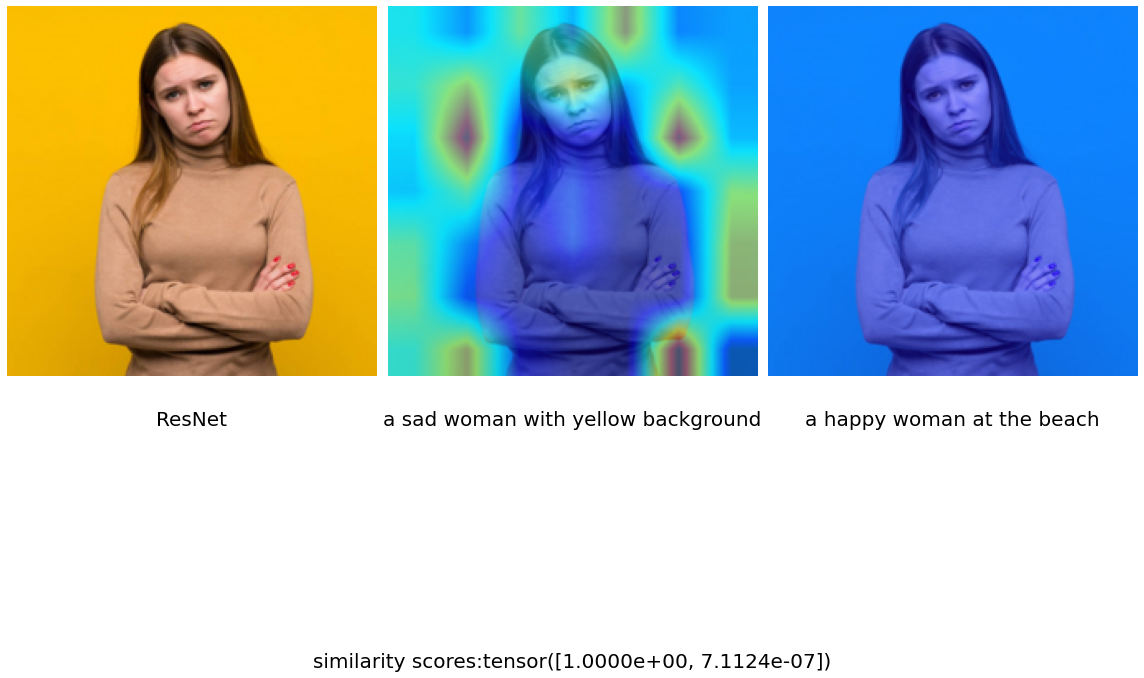

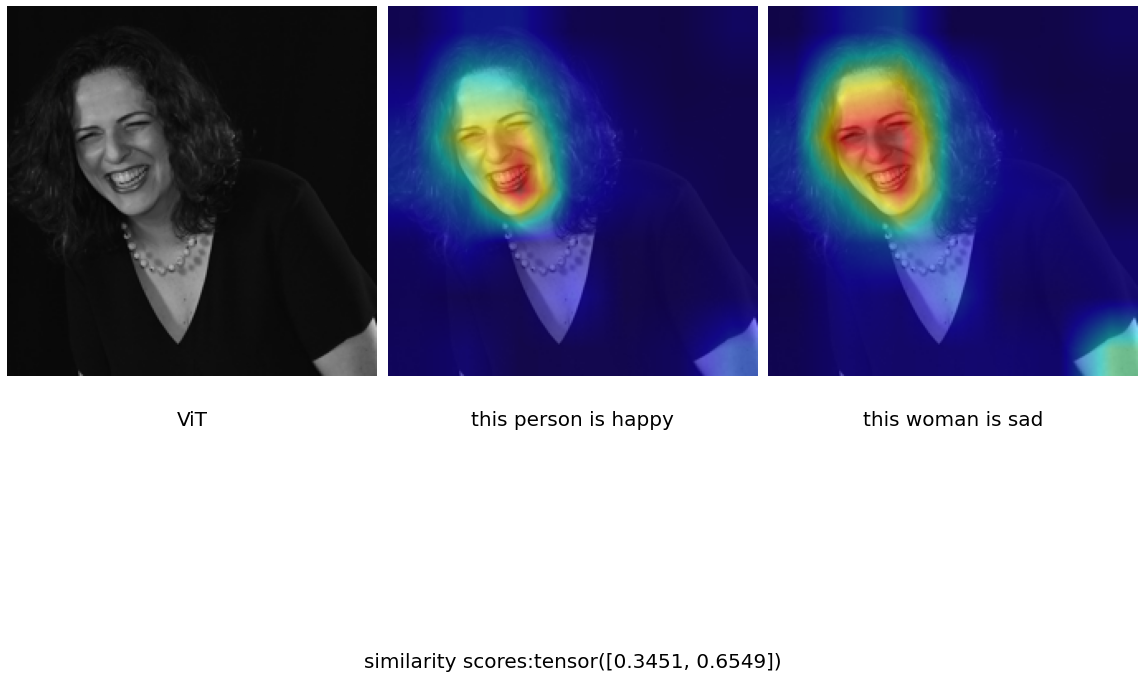

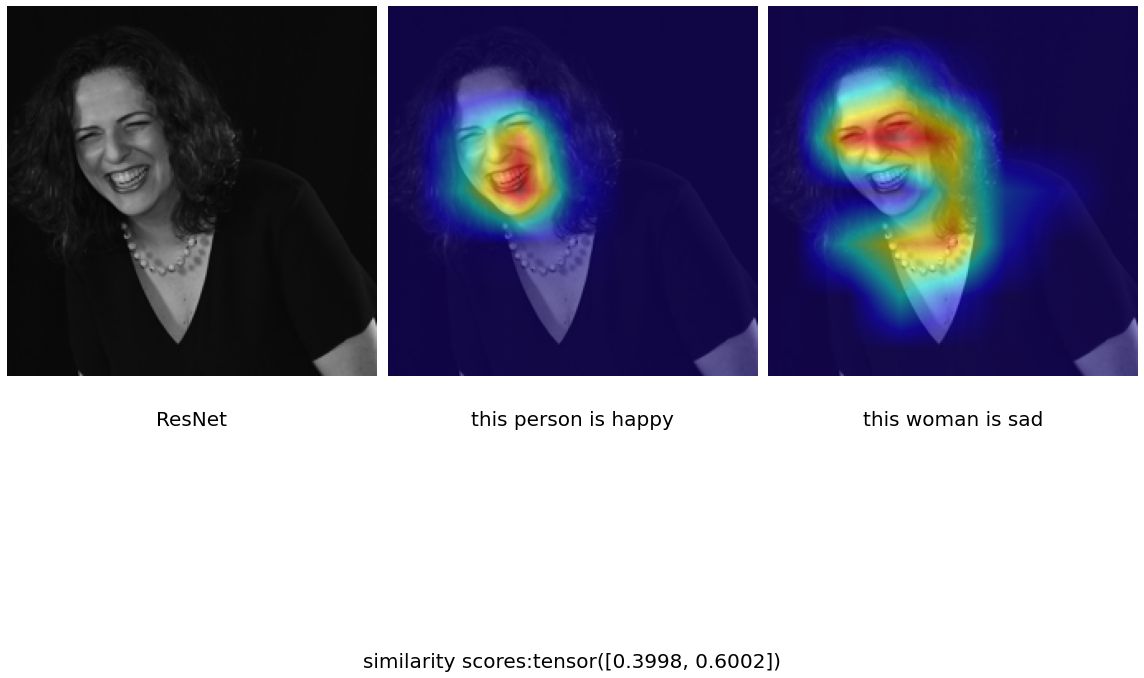

In [5]:
for id_, img_id in enumerate(img_ids):
    
    
    for model_id, model_type in enumerate(model_types):
        
        img_path =  os.path.join(root, img_id + ".jpg")
        image = ori_preprocess(Image.open(img_path))

        plt.figure(figsize=(16, 16))
        plt.subplot(1,3,1)
        plt.imshow(image.permute(1, 2, 0)) 
        plt.axis('off')
        plt.tight_layout()
        plt.title(f"{model_type}", **font, y=-0.15)
      

        p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

       
        texts = text_lists[id_]
        scores = []
        for i,text in enumerate(texts):
            t_text = tokenize(text).to(device)
            plt.subplot(1,3,i+2)
            
            if model_type=="ViT":
                text_features = model_vit.encode_text(t_text)
                similarities = similarity_score(model_vit, p_image, text_features)
                interpret_vit(p_image.type(model_vit.dtype), text_features, model_vit.visual, device)
               
            else:
                text_features = model_rn.encode_text(t_text)
                similarities = similarity_score(model_rn, p_image, text_features)
                interpret_rn(p_image.type(model_rn.dtype), text_features, model_rn.visual, GradCAM, device)
            
            scores.append(similarities.item())
          
            plt.axis('off')
            plt.tight_layout()
            plt.title(f"{text}", **font,y=-0.15)
            
            
        scores = torch.tensor(scores)
        scores = torch.nn.functional.softmax(scores)        
        plt.figtext(0.5, 0.1, f'similarity scores:{scores}', wrap=True, verticalalignment='top', horizontalalignment='center', fontsize=20)       
        plt.savefig(res_dir+f'{model_type}_{img_id}.jpg', bbox_inches='tight')
